**==== 1 - Data import and pre-processing ====**

In [ ]:
# dwonload and unzip dataset
!wget https://files.consumerfinance.gov/ccdb/complaints.csv.zip
!unzip /content/complaints.csv.zip -d /content/complaints.csv
# install NLTK
%pip install nltk

In [ ]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import chi2

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from io import StringIO

from nltk.stem.snowball import SnowballStemmer

from IPython.display import display

In [3]:
# load data into a pandas dataframe from csv file
df = pd.read_csv("/content/complaints.csv/complaints.csv",low_memory=False)
df.shape

(2693834, 18)

In [4]:
# seperate Product & Consumer Complaints columns from initial dataframe
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [5]:
df['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    1119247
Debt collection                                                                  425150
Mortgage                                                                         354535
Credit card or prepaid card                                                      145184
Credit reporting                                                                 140430
Checking or savings account                                                      123369
Credit card                                                                       89190
Bank account or service                                                           86206
Student loan                                                                      67011
Money transfer, virtual currency, or money service                                40671
Vehicle loan or lease                                                             33068
Consumer Loan                   

In [6]:
# check null values on complaints
df.isnull().sum()

Product                               0
Consumer complaint narrative    1750971
dtype: int64

In [7]:
# keep only 'not null' complaints rows
df = df[pd.notnull(df['Consumer complaint narrative'])] 
df.shape

(942863, 2)

In [8]:
# since the dataset is imbalanced
# remove products with complaints < 10,000
# remove products with complaints > 100,000 
counts = df['Product'].value_counts()
df = df[~df['Product'].isin(counts[counts < 10000].index)]
df = df[~df['Product'].isin(counts[counts > 100000].index)]
df.shape

(357009, 2)

In [9]:
df['Product'].value_counts()

Mortgage                                              91969
Credit card or prepaid card                           71415
Checking or savings account                           45394
Credit reporting                                      31588
Student loan                                          30813
Money transfer, virtual currency, or money service    22485
Credit card                                           18838
Vehicle loan or lease                                 17640
Bank account or service                               14885
Payday loan, title loan, or personal loan             11982
Name: Product, dtype: int64

In [10]:
# remove duplicated rows in dataframe
df = df.drop_duplicates(keep="first")
df.shape

(353019, 2)

In [11]:
df['Product'].value_counts()

Mortgage                                              91837
Credit card or prepaid card                           70241
Checking or savings account                           45341
Student loan                                          30670
Credit reporting                                      29827
Money transfer, virtual currency, or money service    22199
Credit card                                           18757
Vehicle loan or lease                                 17357
Bank account or service                               14856
Payday loan, title loan, or personal loan             11934
Name: Product, dtype: int64

In [12]:
# overwrite colum names into 'Product' & 'Consumer_Complaint'
df.columns = ['Product', 'Consumer_Complaint']
df

,Product,Consumer_Complaint
54,Credit card or prepaid card,"Please reopen case XXXX, Nothing has been reso..."
108,Credit card or prepaid card,This was not sent is error i am a consumer by ...
125,Credit card or prepaid card,I bought 2 {$100.00} XXXX gift cards at XXXX a...
138,Vehicle loan or lease,Sun coast credit union committed insurance fra...
147,Vehicle loan or lease,Kia Finance is showing I have a {$10.00} curre...
...,...,...
2693824,Credit card,A reward coupon from XXXX expired and American...
2693826,Credit reporting,Wrong name no XXXX XXXX XXXX and wrong address...
2693828,Credit card,"Automated calls from "" XXXX with Capital One '..."
2693830,Mortgage,My father died in XX/XX/XXXX. Left me his only...


In [13]:
df.shape

(353019, 2)

In [15]:
# assign specific id to each product type
df['cid'] = df['Product'].factorize()[0]
df

,Product,Consumer_Complaint,cid
108,Credit card or prepaid card,This was not sent is error i am a consumer by ...,0
125,Credit card or prepaid card,I bought 2 {$100.00} XXXX gift cards at XXXX a...,0
138,Vehicle loan or lease,Sun coast credit union committed insurance fra...,1
147,Vehicle loan or lease,Kia Finance is showing I have a {$10.00} curre...,1
200,Checking or savings account,Banking services or operating as expected. Sun...,2
...,...,...,...
2693824,Credit card,A reward coupon from XXXX expired and American...,9
2693826,Credit reporting,Wrong name no XXXX XXXX XXXX and wrong address...,7
2693828,Credit card,"Automated calls from "" XXXX with Capital One '...",9
2693830,Mortgage,My father died in XX/XX/XXXX. Left me his only...,4


In [16]:
df['Product'].value_counts()

Mortgage                                              65687
Credit card or prepaid card                           50442
Checking or savings account                           32546
Student loan                                          21942
Credit reporting                                      21563
Money transfer, virtual currency, or money service    15822
Credit card                                           13492
Vehicle loan or lease                                 12443
Bank account or service                               10564
Payday loan, title loan, or personal loan              8518
Name: Product, dtype: int64

In [17]:
# Text Preprocessing using NLTK
# function definition for stemming, tokenizing, removing stop words and 'XX' values from complaint strings using NLTK
# this will be used on TfidfVectorizer
stemmer = nltk.stem.SnowballStemmer('english')
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))
def wordTokenizer(text):
   # tokenize words using nltk word_tokenize operation and remove unnecessary characters
   tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+', '', word.strip('Xx/'))) > 3) ] 
   # convert complaints data into lowercase
   # tf-idf consider same word in different case (lowercase/uppercase/camelcase/mixed) formats as different words. 
   tokens = map(str.lower, tokens)
   # stem and return tokens that are not in stop words list
   stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
   return stems

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


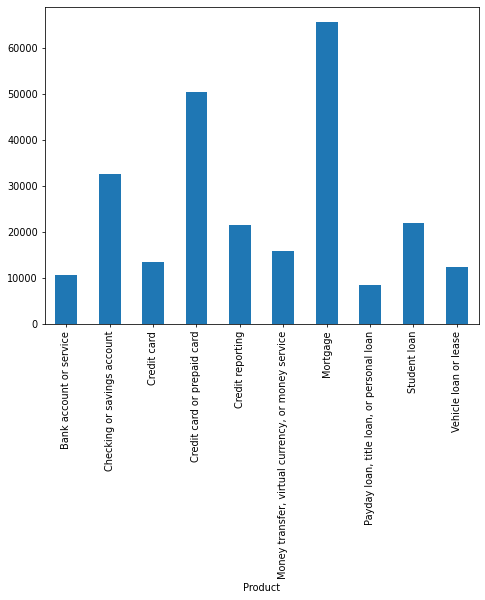

In [18]:
# data distribution among selected product classes
fig = plt.figure(figsize=(8,6),dpi=75.0)
df.groupby('Product').Consumer_Complaint.count().plot.bar(ylim=0)
plt.show()